<center><img src="http://www.exalumnos.usm.cl/wp-content/uploads/2015/06/Isotipo-Negro.gif" title="Title text" width="30%" /></center>

<hr style="height:2px;border:none"/>
<h1 align='center'> MAT-279 Optimización no lineal </h1>

<H3 align='center'>  Modelamiento y optimización en tratamientos del cáncer </H3>
<hr style="height:2px;border:none"/>

**Integrantes**  
* Cristóbal Álvarez
* Eduardo Carriel
* Felipe Pérez
<hr style="height:2px;border:none"/>

# Introducción

El cáncer es una de las enfermedades más letales en la historia de la humanidad, en nuestro país es la segunda causa de fallecimiento y según reportes del año 2019 aproximadamente 45.000 personas se enferman al año y más de la mitad fallecen lo cual deja a nuestro país bajo los parámetros de un país desarrollado en cuanto a la mortalidad de esta patología. Los tratamientos modernos se basan en terapias de radiación para curar los tumores asociados a la enfermedad.

A pesar de aquello, en una etapa de metástasis se deben aplicar otros tipos de tratamiento pues se comienzan a transmitir células cancerígenas desde el tumor a otras partes del cuerpo, ante esto los tratamientos de quimioterapia dan fin a las células cancerígenas pero este proceso a la vez destruye células normales, por lo tanto la administración y optimización de este tratamiento es importante para lograr aniquilar la mayor cantidad de células cancerígenas y minimizar el efecto de los medicamentos en la destrucción de células normales.

Uno de los factores importantes que desata el descontrol del proceso de difusión de células cancerígenas es el hecho de que tras diferentes mutaciones si no ocurre su muerte se puede difundir rápidamente sin control como lo muestra la figura

<center><img src="http://webs.ucm.es/info/quiminorgen/images/cancer2.png" title="Crecimiento de células cancerigenas" width="60%" /></center>



# Problema de control óptimo

En el informe de investigación se presenta el siguiente problema de control óptimo
$$\text{min  } J=-y(T)$$

$$
    \text{st  } \dot{y(t)}=-\lambda y(t)+k(v(t)-v_{th})H(v(t)-v_{th})
$$

$$
    y(0)=\ln(\theta /N_{0})
$$

$$
    \dot{v(t)}=\mu (t) -\gamma v(t)
$$

$$
    v(0)=v_{0}=0
$$

$$    
    0\leq v(t) \leq v_{max}\quad \forall t\in [0,T]
$$

$$
    \int_{0}^{T} v(s)ds\leq v_{cum}
$$

$$
    N(t_{i+1})\leq \eta N(t_{i})\quad \forall  i=0,1,...,M
$$

# Pyomo

En esta sección daremos una breve introducción a Pyomo (citar) que será nuestra herramienta para resolver el problema de forma numérica, esta herramienta viene integrada con Python.

Pyomo fue originalmente diseñado por investigadores del Center for Computing
Research at Sandia National Laboratories y su proyecto COIN-OR. Este software se puede utilizar para resolver problemas de optimización dinámica de la forma
$$ \min J(x,u,p)$$
$$ f(\dot{x}(t),x(t),u(t),p,t)=0 \quad t\in [0,t_f]$$ 
$$ g(x(t),u(t),p,t)\leq 0 \quad t\in [0,t_f]$$
Donde $x$ es una trayectoria o estado del sistema, $u$ es la variable de control a ser optimizada y $p$ es un parámetro independiente del tiempo.

Las componentes que posee Pyomo para realizar modelamiento de problemas como el presentado anteriormente pertenecen a un módulo llamado pyomo.dae el cual permite resolver problemas de control óptimo en ecuaciones diferenciales algebraicas. Las componentes en general para usar pyomo son:
* **Set:** Conjunto de datos que se usará para definir el modelo.
* **Param:** Conjunto de parámetros del modelo.
* **Var:** Variables de decisión.
* **Objective:** Expresión que será minimizada o maximizada en el modelo.
* **Constraint:** Restricciones para los valores que puede tomar el modelo.

En particular la herramienta pyomo.DAE tiene componentes:

* pyomo.dae.ContinuousSet : Representa un dominio acotado y continuo.
* pyomo.dae.DerivativeVar : Representa las derivadas en el modelo pues las variables serán escritas en función de sus derivadas.
* pyomo.dae.Integral : Representa una integral sobre un dominio continuo

Construiremos el modelo usando estas componentes y los parámetros definidos en el informe de investigación.

# Parámetros y parte temporal

In [1]:
from pyomo.environ import *
from pyomo.dae import *
import matplotlib.pyplot as plt
import numpy as np
#Constantes del modelo
crecimiento_tumor = 9.9*1e-4
theta = 1*1e12 #Capacidad de carga
N0 = 1*1e10 #Poblacion tumoral inicial
gamma = 0.27 #Constante inversamente proporcional a la vida media de la droga
vth = 10 #Concentracion de droga para la cual se desactiva su efecto 
vmax = 50 #Maxima concentración de droga permitida
T = 84 #Cantidad de dias 
#Parámetros 
k = 8.4*1e-3 
vcum  = 1.1*1e3
epsilon  = 1/2
#tiempo = np.linspace(0,84,257)
#tiempo

In [2]:
log(theta/N0)

4.605170185988092

In [3]:
#Definición de la parte temporal
from pyomo.environ import *
from pyomo.dae import *

model = ConcreteModel()
model.tf = Param(initialize = T)#Tiempo final

model.t = ContinuousSet( bounds = (0,T)) #tiempos
print("Los tiempos a considerar son:", model.t._fe)

Los tiempos a considerar son: [0, 84]


# Variables e inicialización de parámetros

In [4]:
#Declaración de variables
 
model.u = Var(model.t,domain = NonNegativeReals) 
model.y = Var(model.t,initialize = log(theta/N0)) 
model.v = Var(model.t,initialize =0,domain = NonNegativeReals)

In [5]:
model.lambd = Param(initialize = crecimiento_tumor)
model.theta = Param(initialize = theta)
model.nini = Param(initialize = N0)
model.gamma = Param(initialize = gamma)
model.vth = Param(initialize = vth)
model.vmax = Param(initialize = vmax)
model.k = Param(initialize = k)
model.vcum = Param(initialize = vcum)
model.epsilon = Param(initialize = epsilon)

# Definición de derivadas

In [6]:
model.dydt = DerivativeVar(model.y, wrt = model.t) #y'(t)
model.dvdt = DerivativeVar(model.v, wrt = model.t) #v'(t)

# Función objetivo

In [7]:
model.obj = Objective(expr = - model.y[model.tf] ,sense = minimize)

# Condiciones iniciales

# Restricciones dinámicas

In [8]:
def _init(m):
    yield m.y[0] == log(theta/N0)
    yield m.v[0] == 0
model.init_conditions = ConstraintList(rule= _init)

In [9]:
def _vdot(m,t):
    return m.dvdt[t] == m.u[t] - gamma*m.v[t]
model.vdot = Constraint(model.t,rule = _vdot)

def _ydot2(m,t): #m:modelo, t:tiempo
    return m.dydt[t] == - crecimiento_tumor*m.y[t] + k*(m.v[t] - vth)*np.heaviside(value(m.v[t] - vth),0)
    
model.ydot =  Constraint(model.t,rule = _ydot2)


# Restricciones integrales

In [10]:
def _intV(m,t):
    return m.v[t]
model.integral_v = Integral(model.t,wrt = model.t,rule=_intV) #integral de v

In [11]:
def _integral_constraint(m,t):
    return m.integral_v <= m.vcum #analizar caso == y variar vcum
model.int_const = Constraint(model.t,rule =_integral_constraint )

In [12]:
def _vT(m,t):
    #Teorema
    return m.v[t] == m.vmax #ver que pasa en este caso v(t)<=vmax y v(T)<=vmax
model.v_final = Constraint(model.t,rule =_vT)

# Condición de disminución por periodos

In [13]:
discretizer = TransformationFactory("dae.collocation") #Estudiar 
discretizer.apply_to(model,nfe = 12, ncp = 6, scheme = "LAGRANGE-RADAU") #12 puntos, 6 puntos de colocación

In [14]:
model.t._fe

[0, 7.0, 14.0, 21.0, 28.0, 35.0, 42.0, 49.0, 56.0, 63.0, 70.0, 77.0, 84]

In [15]:
model = discretizer.reduce_collocation_points(model,
                                             var = model.u,
                                             ncp=6,
                                             contset = model.t)

In [16]:
def _disminucion1(m):
    return m.y[21] - m.y[0]+ log(m.epsilon)>=0
model.dis1 = Constraint(rule = _disminucion1)
def _disminucion2(m):
    return m.y[42] - m.y[21]+ log(m.epsilon)>=0
model.dis2 = Constraint(rule = _disminucion2)
def _disminucion3(m):
    return m.y[63] - m.y[42]+ log(m.epsilon)>=0
model.dis3 = Constraint(rule = _disminucion3)
def _disminucion4(m):
    print(value(m.y[84]))
    print(value(m.y[21]))
    return m.y[84] - m.y[63]+ log(m.epsilon)>=0
model.dis4 = Constraint(rule = _disminucion4)

4.605170185988092
4.605170185988092


# Discretización y solución via ipopt

In [17]:
solver = SolverFactory("ipopt") #Estudiar
status = solver.solve(model,tee = True)
status

Ipopt 3.11.1: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

NOTE: You are using Ipopt by default with the MUMPS linear solver.
      Other linear solvers might be more efficient (see Ipopt documentation).


This is Ipopt version 3.11.1, running with linear solver mumps.

Number of nonzeros in equality constraint Jacobian...:     1592
Number of nonzeros in inequality constraint Jacobian.:     5337
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      365
                     variables with only lower bounds:      146
                variables with lower and upper bounds:        0


{'Problem': [{'Lower bound': -inf, 'Upper bound': inf, 'Number of objectives': 1, 'Number of constraints': 442, 'Number of variables': 365, 'Sense': 'unknown'}], 'Solver': [{'Status': 'warning', 'Message': 'Ipopt 3.11.1\\x3a Converged to a locally infeasible point. Problem may be infeasible.', 'Termination condition': 'infeasible', 'Id': 200, 'Error rc': 0, 'Time': 9.349945545196533}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

In [18]:
model.obj.display()

obj : Size=1, Index=None, Active=True
    Key  : Active : Value
    None :   True : -7.377758868228103


In [19]:
model.display()

Model unknown

  Variables:
    u : Size=73, Index=t
        Key       : Lower : Value               : Upper : Fixed : Stale : Domain
                0 :     0 : 0.08437294930173439 :  None : False : False : NonNegativeReals
         0.278669 :     0 :                 0.0 :  None : False : False : NonNegativeReals
         1.386094 :     0 :                 0.0 :  None : False : False : NonNegativeReals
         3.065824 :     0 :  0.0652399209951454 :  None : False : False : NonNegativeReals
          4.86825 :     0 :                 0.0 :  None : False : False : NonNegativeReals
         6.310254 :     0 :   10.76131459810582 :  None : False : False : NonNegativeReals
              7.0 :     0 :  32.380529492093075 :  None : False : False : NonNegativeReals
         7.278669 :     0 :                 0.0 :  None : False : False : NonNegativeReals
         8.386094 :     0 :                 0.0 :  None : False : False : NonNegativeReals
        10.065824 :     0 :                 0.0

In [20]:
model.pprint()

1 Set Declarations
    init_conditions_index : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    2 : {1, 2}

1 RangeSet Declarations
    t_domain : Dimen=1, Size=Inf, Bounds=(0, 84)
        Key  : Finite : Members
        None :  False : [0..84]

10 Param Declarations
    epsilon : Size=1, Index=None, Domain=Any, Default=None, Mutable=False
        Key  : Value
        None :   0.5
    gamma : Size=1, Index=None, Domain=Any, Default=None, Mutable=False
        Key  : Value
        None :  0.27
    k : Size=1, Index=None, Domain=Any, Default=None, Mutable=False
        Key  : Value
        None : 0.008400000000000001
    lambd : Size=1, Index=None, Domain=Any, Default=None, Mutable=False
        Key  : Value
        None : 0.00099
    nini : Size=1, Index=None, Domain=Any, Default=None, Mutable=False
        Key  : Value
        None : 10000000000.0
    tf : Size=1, Index=None, Domain=Any, Default=None, Mutable=False


In [21]:
L = [model.t.data()[i] for i in range(len(model.t.data()))] #Tiempo

In [22]:
u = [model.u[i].value for i in L] 

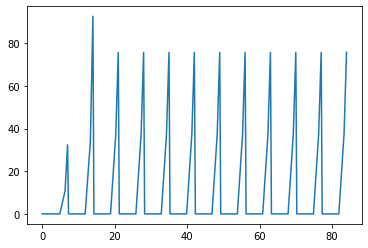

In [23]:
plt.plot(L,u)


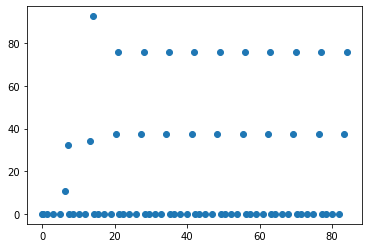

In [24]:
plt.scatter(L,u)


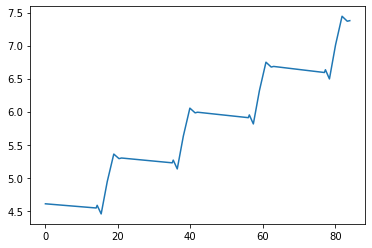

In [25]:
y = [model.y[i].value for i in L]
plt.plot(L,y)

In [26]:
ynegativo=[]
for i in y:
    ynegativo.append(-i)

In [27]:
N = theta*np.exp(ynegativo)

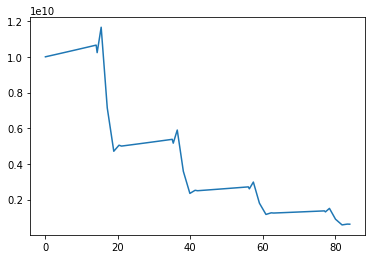

In [28]:
plt.plot(L,N)

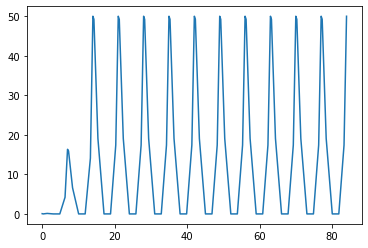

In [29]:
v = [model.v[i].value for i in L]
plt.plot(L,v)

In [30]:
N[-1]/N[0]*100

6.2500002499980525

In [31]:
0.7*84

58.8

In [32]:
N[-1]

625000024.9998567